# Imports and functions

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import timeit

In [2]:
citiesnp = np.genfromtxt('cities.csv', delimiter=',', skip_header = 1) # load as numpy array

In [3]:
def not_prime(n):
    if n == 2:
        return False
    if n % 2 == 0 or n <= 1:
        return True

    sqr = int(math.sqrt(n)) + 1

    for divisor in range(3, sqr, 2):
        if n % divisor == 0:
            return True
    return False

def is_prime(n):
    if n % 2 == 0 and n > 2: 
        return False
    return all(n % i for i in range(3, int(math.sqrt(n)) + 1, 2))

np_not_prime = np.vectorize(not_prime)

nums = np.arange(0,len(citiesnp))

not_primes_bool = np_not_prime(nums)

def np_total_length(r, c):
    # v8
    r = np.concatenate(([0], r))
    c = c[r, :]
    cs = np.roll(c, -1, axis =0)
    cid = cs[:,0].astype(int)
    d = np.sqrt((c[:,1] - cs[:,1])**2 + (c[:,2] - cs[:,2])**2)
    idx = np.arange(9, len(c), 10)
    pc = cid[idx]
    sel = (idx+1)[not_primes_bool[pc]]
    d[sel-1] *= 1.1
    
    return np.sum(d)

In [4]:
def route_fitness(r, c):
    return 1 / np_total_length(r, c)

In [5]:
np.random.seed(4)
idx = np.random.permutation(range(1, len(citiesnp)))

In [6]:
np_total_length(idx, citiesnp)

446925531.9322754

In [7]:
cities_sub = citiesnp[0:26]

In [8]:
np.random.seed(3)
idx = np.random.permutation(range(1,26))

In [9]:
np_total_length(idx, cities_sub)

60566.12398696876

# Genetic algorithm

### Generate Population

In [10]:
def pop_gen(n, pop_size):
    arr = np.repeat([np.arange(1, n)], pop_size, 0)
    return np.apply_along_axis(np.random.permutation, 1, arr)    

### Evaluate population

In [11]:
def pop_eval(array, pop, fit_fun):
    return np.apply_along_axis(fit_fun, 1, pop, c = array)

In [12]:
def pop_stats(scores):
    mean = np.mean(scores)
    med = np.median(scores)
    best = np.max(scores)
    return med, mean, best

### Selection

In [13]:
def roulette_selection(pop, scores, size):
    if size % 2 != 0:
        size += 1
    p = scores/np.sum(scores)
    sel = np.random.choice(len(pop), size, replace = True, p = p).reshape((size//2, 2))    
    return np.concatenate((pop[sel][:,0], pop[sel][:,1]), 1)

In [14]:
def roulette_selection2(pop, scores, size):
    if size % 2 != 0:
        size += 1
    p = scores/np.sum(scores)
    sel = np.random.choice(len(pop), size, replace = True, p = p).reshape((size//2, 2))
    return pop[sel]

### Crossover

In [15]:
def pairwise_crossover(p):
    n = len(p) // 2
    p0 = p[:n]
   
    p1 = p[n:]
    swath = np.random.randint(1, n)
    
    cut1 = np.random.randint(0, n - swath)
    cut2 = cut1 + swath
    
    off = np.repeat([0], n)
    
    sel = p0[cut1:cut2]
    off[cut1:cut2] = sel
    sel = p1[~np.isin(p1, sel)]
    off[0:cut1] = sel[0:cut1]

    off[cut2:] = sel[cut1:]
    return off   

In [16]:
def two_point_crossover(pa):
    return np.apply_along_axis(pairwise_crossover, 1, pa)

In [17]:
def two_point_crossover2(p):
    n = p.shape[2]
    swath = np.random.randint(1, n)
    
    cut1 = np.random.randint(0, n - swath)
    cut2 = cut1 + swath
    
    # print(cut1, cut2)
    
    ps0 = p.shape[0]
    off = np.zeros((ps0, n))
    
    sel = p[:, 0, cut1:cut2]
    off[:, cut1:cut2] = sel
    
    p1 = p[:, 1]
    sel = np.array(np.split(p1[~np.array([(np.isin(p1[i],sel[i])) for i in range(len(sel))])], ps0))
    
    off[:, 0:cut1] = sel[:, 0:cut1]
    off[:, cut2:] = sel[:, cut1:]
    return off   

In [18]:
def mod_two_point_crossover2(p):
    # http://www.rroij.com/open-access/enhanced-order-crossover-for-permutationproblems.php?aid=50178
    n = p.shape[2] 
    swath = np.random.randint(1, n // 7)
    
    cut1 = np.random.randint(0, n - swath)
    cut2 = cut1 + swath
    
    # print(cut1, cut2)
    
    ps0 = p.shape[0]
    off = np.zeros((ps0, n))
    
    sel = p[:, 0, cut1:cut2]
    off[:, cut1:cut2] = sel
    
    p1 = p[:, 1]
    sel = np.array(np.split(p1[~np.array([(np.isin(p1[i],sel[i])) for i in range(len(sel))])], ps0))
    
    off[:, 0:cut1] = sel[:, 0:cut1]
    off[:, cut2:] = sel[:, cut1:]
    return off   

In [19]:
def two_point_crossover3(p):
    n = p.shape[2]
    swath = np.random.randint(1, n)
    cut1 = np.random.randint(0, n - swath)
    cut2 = cut1 + swath
    ps0 = p.shape[0]
    
    off = np.zeros((ps0, n))
    sel = p[:, 0, cut1:cut2]
    off[:, cut1:cut2] = sel
    p1 = p[:, 1]
    
    result = np.empty_like(p1)
    for i in range(ps0):
        result[i] = ~np.isin(p1[i], sel[i])
    result = result.astype(bool)
    
    sel = np.array(np.split(p1[result], ps0))
    
    off[:, 0:cut1] = sel[:, 0:cut1]
    off[:, cut2:] = sel[:, cut1:]
    return off

### Mutation

In [20]:
def swap_mutation(perm):
    n = len(perm)
    i = np.random.choice(n, 2, replace = False)
    perm[i] = perm[i[::-1]]
    return perm    

In [21]:
def reverse_mutation(perm):
    n = len(perm) - 1
    i = np.random.choice(n, 1)[0]
    perm[i:i+2] = perm[i:i+2][::-1]
    return(perm)

In [22]:
def shift_mutation(perm):
    n = len(perm)
    i = np.random.choice(n, 2, replace = False)
    i = np.sort(i)
    i0 = i[0]
    i1 = i[1]
    perm = np.concatenate((perm[i1:], perm[i0:i1], perm[:i0][::-1]))
    return perm

In [23]:
# def centre_inverse_mutation(perm):
    

In [24]:
def pop_mutation(pop, mut_fun, mut_perc):
    sel = np.random.choice(len(pop), int(len(pop) * mut_perc), replace = False)
    pop[sel] = np.apply_along_axis(mut_fun, 1, pop[sel])
    return pop

### GA

In [25]:
def GA(array, n_gen, pop_size, parent_size, fit_fun, mut_funs, mut_perc, sel_fun,
       cross_fun = None, max_no_change = 100, verbose = False):
    n = len(array)
    
    # init pop
    pop = pop_gen(n, pop_size)
    
    scores = pop_eval(array, pop, fit_fun)
    med, mean, best = pop_stats(scores)
    
    ov_best = best # overall best score init
    best_pop = pop # overall best pop init
    med_trace = np.array([med]) # trace of median scores init
    mean_trace = np.array([mean]) # trace of mean scores init
    best_trace = np.array([best]) # trace of best scores init
    
    iter_no_change = 0
    i = 0
    
    while i < n_gen:
        # pass n_gen = np.inf to iterate until iter_no_change >= max_no_change
        
        # select best parents
        if verbose: start = datetime.now()
        parents = sel_fun(pop, scores, parent_size)
        if verbose:
            end = datetime.now()
            sel_sec = (end-start).total_seconds()
        
        if verbose: start = datetime.now()
        if not (cross_fun is None):
            ## no crossover
            ## j = np.random.choice(2)
            ## offs = parents[:, j]
            ## else:
            
            # generate offsprings
            offs = cross_fun(parents)   
        if verbose:
            end = datetime.now()
            gen_sec = (end-start).total_seconds()
        
        # replace worst in pop with offs
        if not (cross_fun is None):
            sort = np.argsort(scores)
            pop[sort[:len(offs)]] = offs
        
        # mutate pop
        if verbose: start = datetime.now()
        for fun in mut_funs:
            pop = pop_mutation(pop, fun, mut_perc)
        if verbose:
            end = datetime.now()
            mut_sec = (end-start).total_seconds()
        
        # evaluate
        if verbose: start = datetime.now()
        scores = pop_eval(array, pop, fit_fun)
        if verbose:
            end = datetime.now()
            ev_sec = (end-start).total_seconds()
        
        # update traces
        med, mean, best = pop_stats(scores) # new med, mean best scores
        
        if best > ov_best:
            ov_best = best
            best_pop = pop
            iter_no_change = 0
            
        med_trace = np.concatenate((med_trace, [med]))
        mean_trace = np.concatenate((mean_trace, [mean]))
        best_trace =  np.concatenate((best_trace, [best]))
        
        if verbose:
            if i % 10 == 0:
                text = [i, iter_no_change, sel_sec, gen_sec, mut_sec, ev_sec]
                text.append(sum(text[2:]))
                text.append(1/ov_best)
                print('Iter {}, ItNoChange {}, Sel {}, Cross {}, Mut {}, Ev {}, Tot {}, Best {}'.format(*text)) 
        
        i += 1
        iter_no_change += 1
        if iter_no_change >= max_no_change:
            break
        
    best_scores = pop_eval(array, best_pop, fit_fun)
    bpe = best_pop[np.argmax(best_scores)]
    

    
    return med_trace, mean_trace, best_trace, ov_best, bpe

In [26]:
def plot_GA(a, b, c, n):
    fig, ax = plt.subplots(figsize=(10,6))

    x = np.arange(0, len(c), n)
    l1 = ax.plot(x, a[::n])[0]
    l2 = ax.plot(x, b[::n])[0]
    l3 = ax.plot(x, c[::n])[0]
    
    line_labels = ["Median", "Average", "Best"]
    
    fig.legend([l1, l2, l3], line_labels, bbox_to_anchor=(0.7, 0.3))
    
    plt.show()

### Testing

In [27]:
np.random.seed(4)
a1, b1, c1, d1, e1 = GA(cities_sub, np.inf, 20, 10, route_fitness, [reverse_mutation], 0.3,
                        roulette_selection2, two_point_crossover2, verbose = 0)

In [28]:
e1

array([ 5, 15, 20,  3, 25,  9,  1,  7, 24, 12, 18,  4,  6,  8, 14, 13, 11,
       19, 21, 16, 17, 23,  2, 22, 10])

In [31]:
c1[-1],

(3.6472859483646505e-05,)

In [32]:
route_fitness(e1, cities_sub)

3.6472859483646505e-05

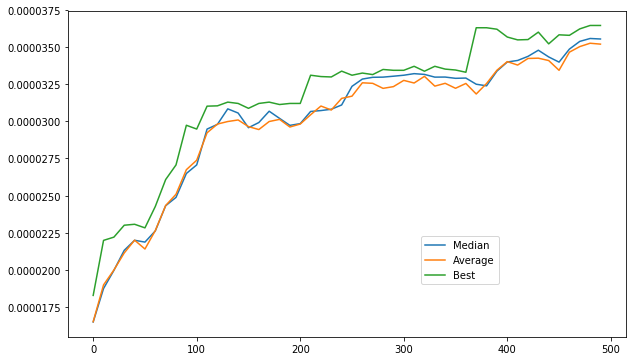

In [33]:
plot_GA(a1, b1, c1, 10)

More than one mutation.

In [34]:
np.random.seed(4)
a1, b1, c1, d1, e1 = GA(cities_sub, np.inf, 20, 20, route_fitness, [reverse_mutation, swap_mutation], 0.3,
                    roulette_selection2, cross_fun=mod_two_point_crossover2, max_no_change = 1000)

In [35]:
1/c1[-1], 1/d1 #tour length of best route

(26492.246907063116, 22504.304605246507)

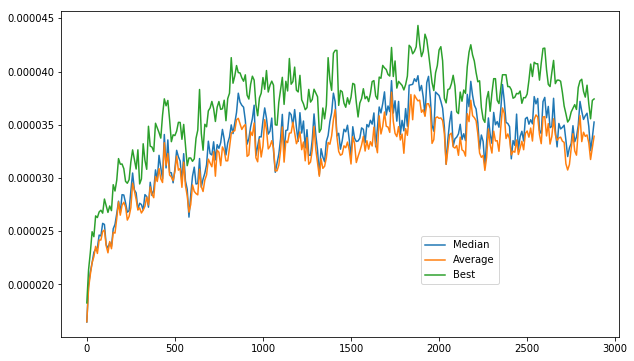

In [36]:
plot_GA(a1, b1, c1, 10)

In [37]:
np.random.seed(4)
a1, b1, c1, d1, e1 = GA(cities_sub, np.inf, 20, 6, route_fitness, [shift_mutation], 0.1,
                    roulette_selection2, cross_fun=mod_two_point_crossover2, max_no_change = 1000)

In [38]:
1/c1[-1], 1/d1 #tour length of best route

(21221.4891261565, 20206.289206598216)

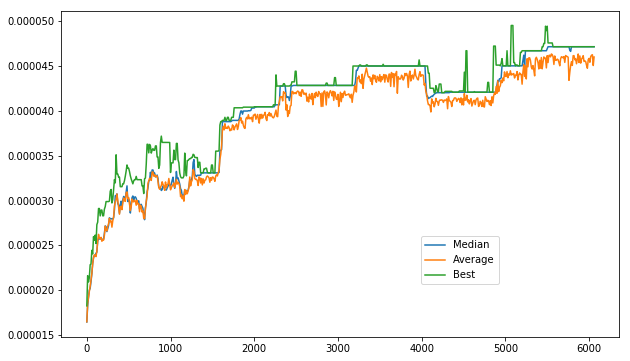

In [39]:
plot_GA(a1, b1, c1, 10)

## Performance testing

In [ ]:
pop = pop_gen(len(citiesnp), 10)

In [ ]:
scores = pop_eval(citiesnp, pop, route_fitness)

In [ ]:
scores

In [ ]:
timeit.timeit('roulette_selection2(pop, scores, 10)', number=1000, globals=globals())

In [ ]:
timeit.timeit('roulette_selection(pop, scores, 10)', number=1000, globals=globals())

In [ ]:
parents1 = roulette_selection(pop, scores, 10)

In [ ]:
parents2 = roulette_selection2(pop, scores, 10)

In [ ]:
two_point_crossover(parents1)

In [ ]:
two_point_crossover2(parents2)

In [ ]:
mod_two_point_crossover2(parents2)

In [ ]:
two_point_crossover3(parents2)

In [ ]:
timeit.timeit('two_point_crossover(parents1)', number=100, globals=globals())

In [ ]:
timeit.timeit('two_point_crossover2(parents2)', number=100, globals=globals())

In [ ]:
timeit.timeit('mod_two_point_crossover2(parents2)', number=100, globals=globals())

In [ ]:
timeit.timeit('two_point_crossover3(parents2)', number=100, globals=globals())